In [3]:
%%writefile run_em1d.py
from SimPEG import *
from simpegem1d import *
from scipy.constants import mu_0
import numpy as np
FDsurvey = BaseEM1D.EM1DSurveyFD()
FDsurvey.rxLoc = np.array([0., 0., 100.+30.])
FDsurvey.srcLoc = np.array([0., 0., 100.+30.])
FDsurvey.fieldtype = 'secondary'
FDsurvey.rxType = 'Hz'
FDsurvey.srcType = 'VMD'
FDsurvey.offset = np.r_[8., 8., 8.]
cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(15)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]
FDsurvey.depth = depth
FDsurvey.topo = topo
FDsurvey.LocSigZ = LocSigZ
# FDsurvey.frequency = np.logspace(3, 5, 11)
FDsurvey.frequency = np.r_[900., 7200., 56000]
FDsurvey.Nfreq = FDsurvey.frequency.size
FDsurvey.Setup1Dsystem()
FDsurvey.SetOffset()
sig_half = 1e-4
sig_blk = 1e-2
chi_half = 0.
expmap = BaseEM1DMap(mesh1D)
sig  = np.ones(nlay)*sig_half
blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

WT0, WT1, YBASE = DigFilter.LoadWeights()
# options = {'filter_type': 'key_101'}
prob = EM1D(
    mesh1D, sigmaMap=expmap, filter_type='key_101',
    jacSwitch=True,
    CondType='Real',
    chi= np.zeros(FDsurvey.nlay)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)
d_true = FDsurvey.dpred(m_true)
FDsurvey.dtrue = d_true
std = 0.05
floor = 1e-16
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)
m0 = np.log(np.ones_like(sig)*1e-3)
reg = Regularization.Tikhonov(mesh1D)
opt = Optimization.InexactGaussNewton(maxIter = 20)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
reg.alpha_s = 1.
reg.alpha_x = 0.1
reg.alpha_y = 0.1
reg.alpha_z = 0.1

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

Overwriting run_em1d.py


In [4]:
!python run_em1d.py

>> Use Key 101 filter for Hankel Tranform
compute fields
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
compute fields
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.64e+00  2.98e+03  0.00e+00  2.98e+03    2.86e+03      0              
compute fields
   1  3.82e+00  7.36e+02  1.38e+01  7.89e+02    4.70e+02      0              
compute fields
   2  1.91e+00  3.09e+02  5.23e+01  4.09e+02    9.33e+01      0   Skip BFGS  
compute fields
   3  9.55e-01  1.69e+02  8.84e+01  2.54e+02    8.95e+01      0   Skip BFGS  
compute fields
   4  4.77e-01  5

In [4]:
%%time


NameError: name 'inv' is not defined

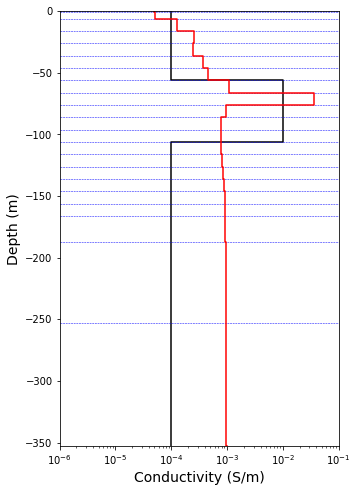

In [26]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e-1), **{'color':'r'})

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# !python run_em1d.py

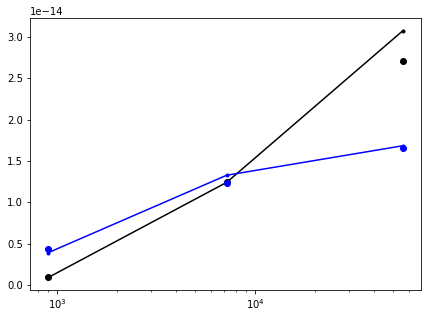

In [12]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.Nfreq], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.Nfreq:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.Nfreq], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.Nfreq:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.Nfreq], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.Nfreq:], 'r*')
axes.set_xscale('log')

In [13]:
from scipy.linalg.blas import cgemm
import numpy as np

In [14]:
a = np.ones((22, 101), dtype=complex)
x = np.ones(101, dtype=complex)
alpha = complex(1.)
# cgemv(a, x, )

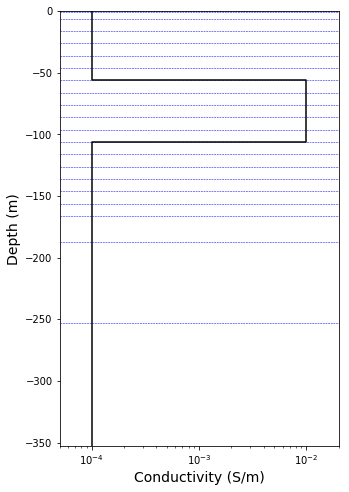

In [18]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [20]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :        9
  InexactGaussNewton.doStartIteration     :        9
  InexactGaussNewton.scaleSearchDirection :        9

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 4.04e-04, 1.01e-02,   25x
  EM1D.Jvec_approx                        : 4.46e-04, 1.11e-02,   25x
  InexactGaussNewton.findSearchDirection  : 8.94e-03, 8.04e-02,    9x
  InexactGaussNewton.minimize             : 1.80e+00, 1.80e+00,    1x
  InexactGaussNewton.modifySearchDirection: 1.52e-01, 1.37e+00,    9x
  InexactGaussNewton.projection           : 8.00e-05, 3.36e-03,   42x


In [21]:
dpredall = []
for i in range(len(xc)):
    dpredtemp = FDsurvey.dpred(xc[i])
    dpredall.append(dpredtemp)


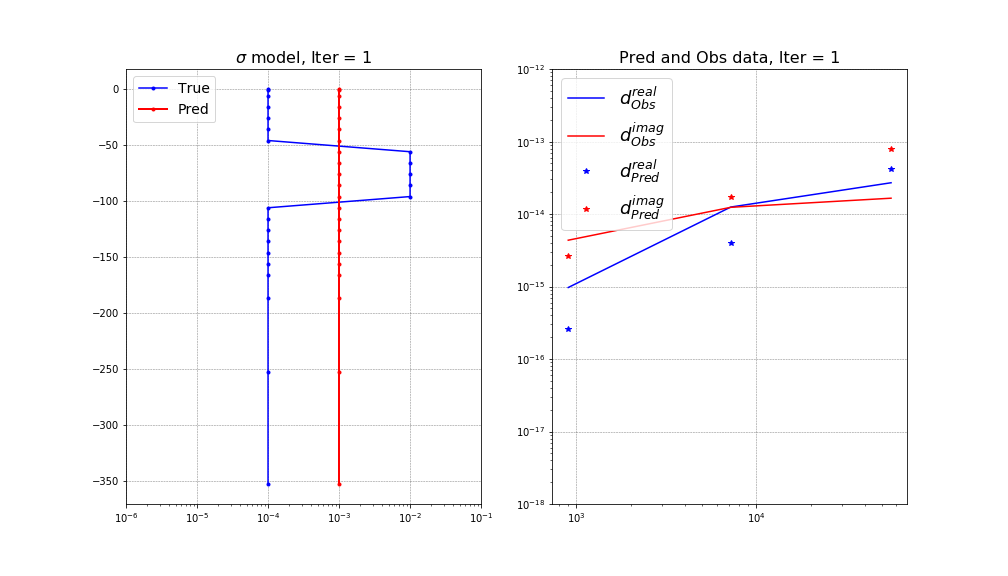
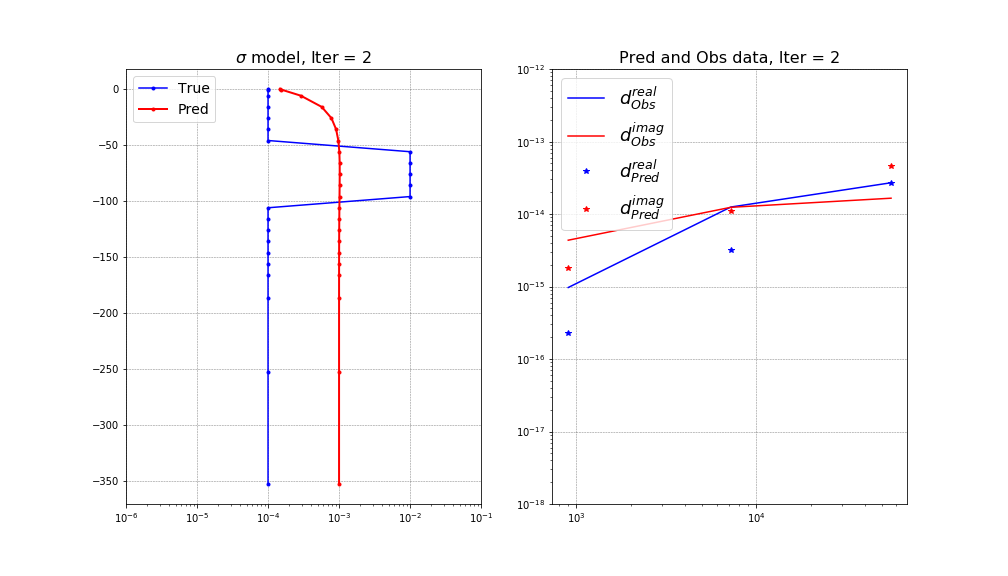
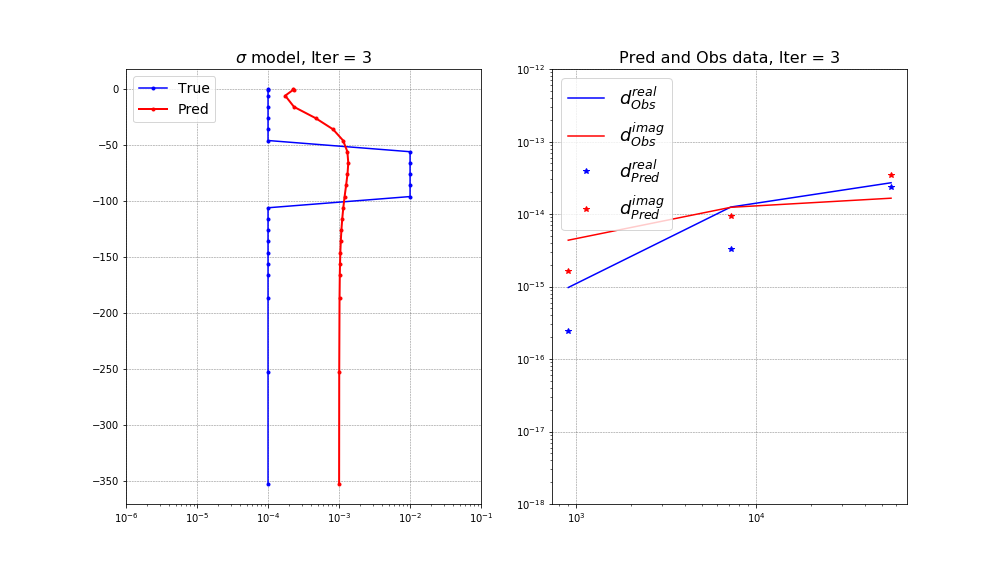
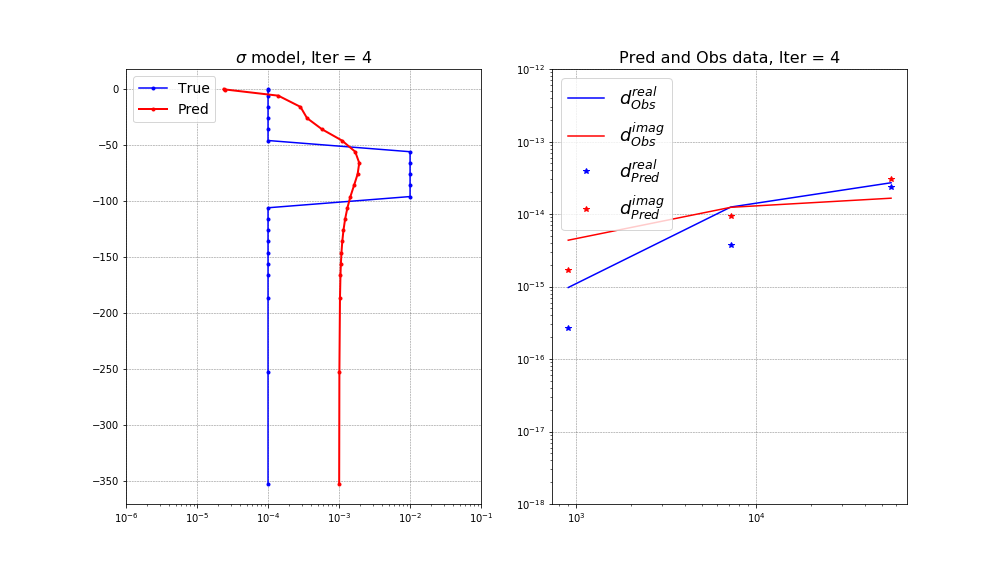
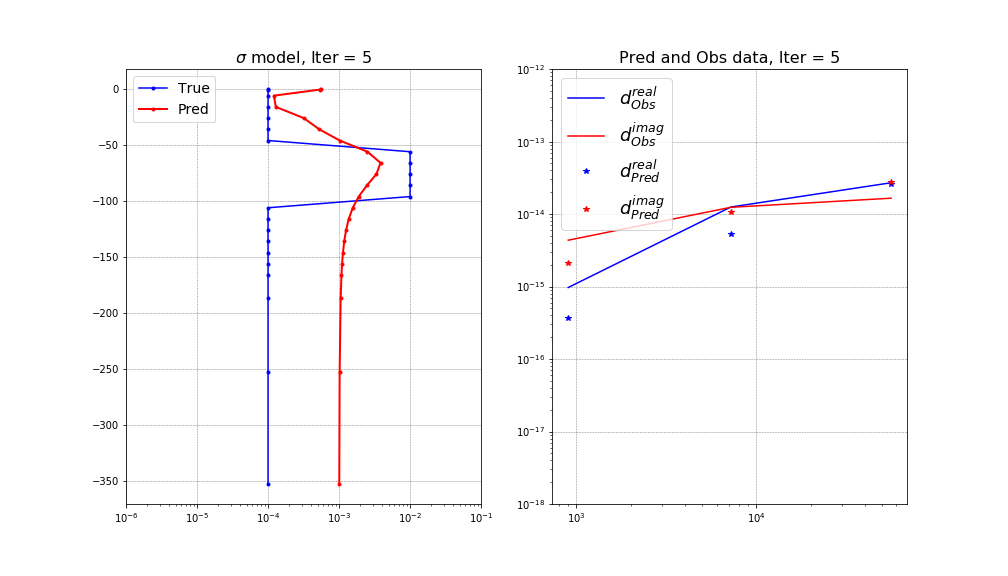
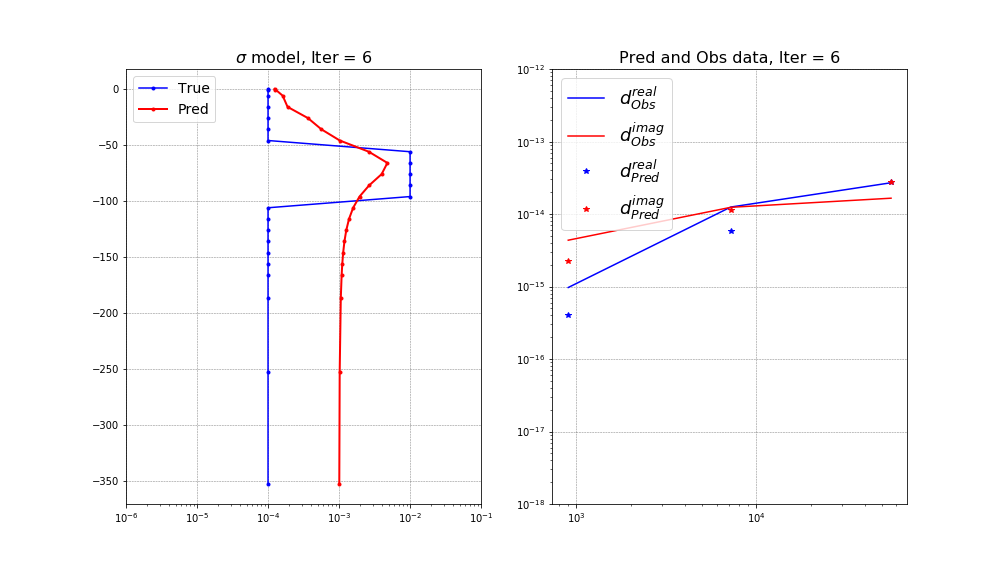
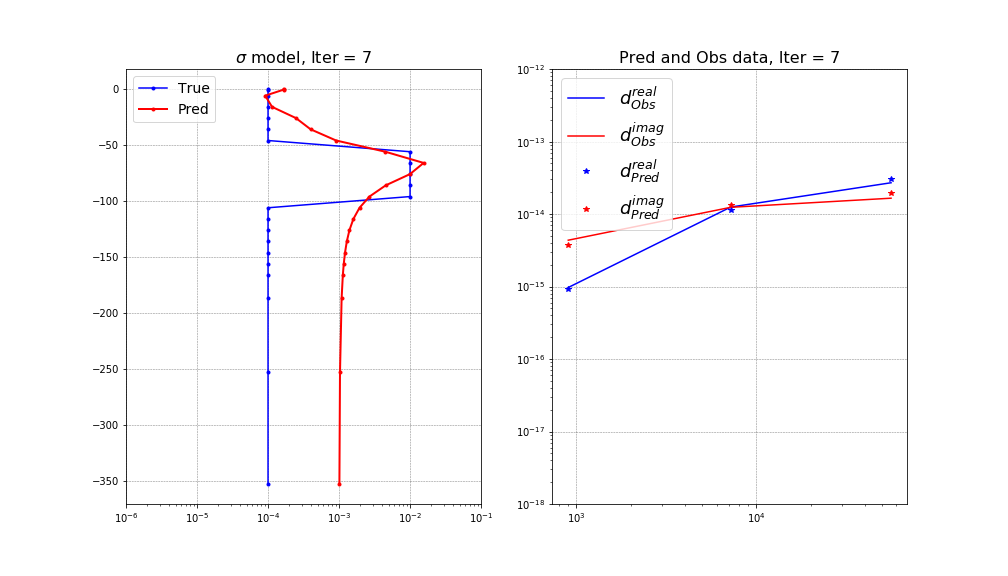
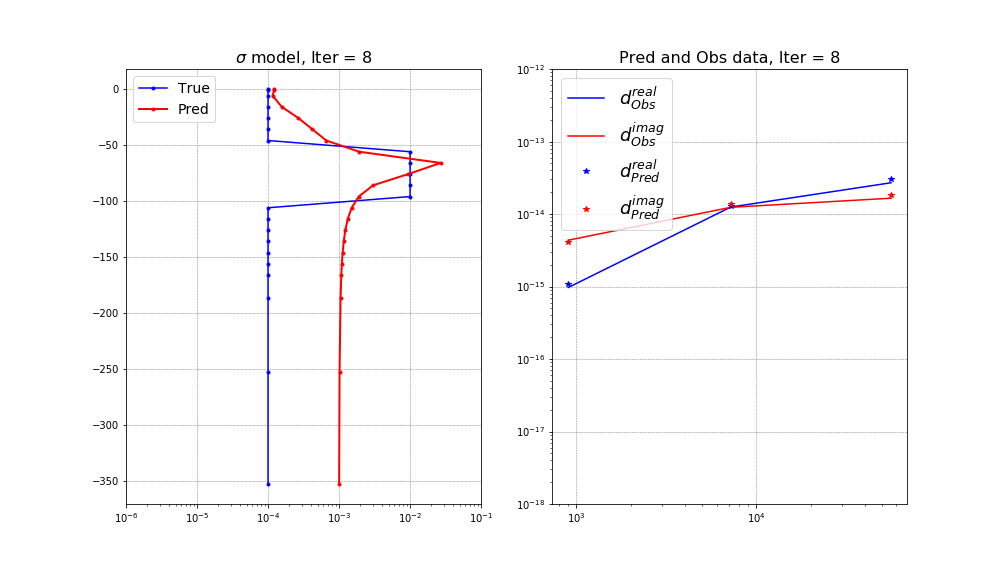
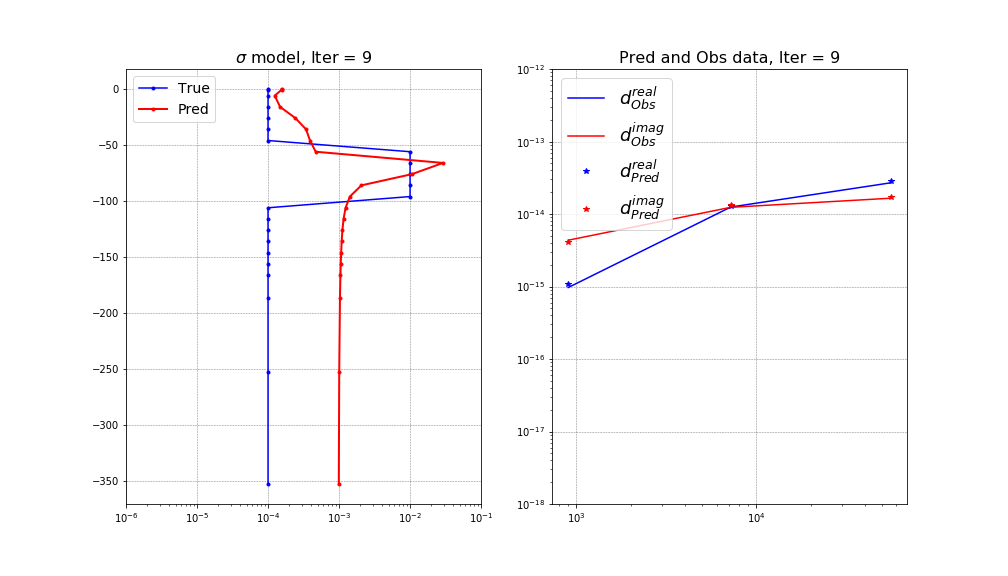

In [22]:
from JSAnimation import IPython_display
from matplotlib import animation

fig, ax = subplots(1,2, figsize=(14, 8))
ax[0].plot(sig, LocSigZ,  'b.-')
ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[0:FDsurvey.Nfreq]), 'b-')
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[FDsurvey.Nfreq:]), 'r-')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(1e-6, 1e-1)
ax[1].set_ylim(1e-18, 1e-12)

frame1, = ax[0].plot([], [],  'r.-', lw=2)
frame2, = ax[1].plot([], [],  'b*' , lw=2)
frame3, = ax[1].plot([], [],  'r*' , lw=2)

def animate(i_id):
#     
    frame1.set_data(expmap*xc[i_id], LocSigZ)
    frame2.set_data(FDsurvey.frequency, abs(dpredall[i_id][:FDsurvey.Nfreq]))
    frame3.set_data(FDsurvey.frequency, abs(dpredall[i_id][FDsurvey.Nfreq:]))
    
    ax[0].legend(('True', 'Pred'), loc=2, fontsize = 14)
    ax[1].legend(('$d^{real}_{Obs}$', '$d^{imag}_{Obs}$', '$d^{real}_{Pred}$', '$d^{imag}_{Pred}$'), loc=2, fontsize = 18)
    ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
    ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
    return frame1, frame2, frame3

animation.FuncAnimation(fig, animate, frames=len(xc), interval=40, blit=True)

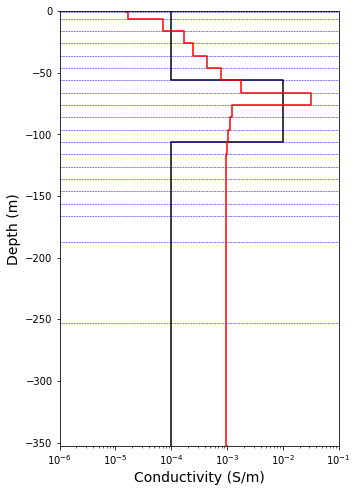

In [16]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e-1), **{'color':'r'})